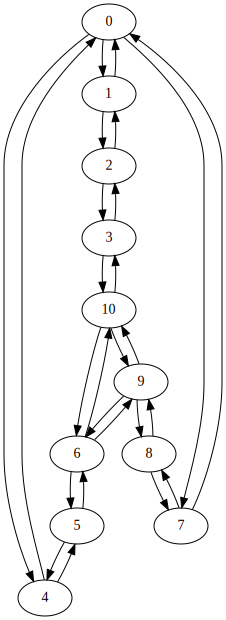

In [249]:
#!pip install graphviz
from graphviz import Digraph
import numpy as np
dot = Digraph()
adj_graph = np.zeros((11,11))
adj_graph[0,1] = 1
adj_graph[0,4] = 1
adj_graph[1,2] = 1
adj_graph[2,3] = 1
adj_graph[4,5] = 1
adj_graph[5,6] = 1
adj_graph[0,7] = 1
adj_graph[7,8] = 1
adj_graph[8,9] = 1
adj_graph[3,10] = 1
adj_graph[6,10] = 1
adj_graph[9,10] = 1
adj_graph[6,9] = 1

adj_graph += adj_graph.transpose()



for r in range(0, adj_graph.shape[0]):
    for c in range(0, adj_graph.shape[1]):
        if adj_graph[r, c] > 0:
            dot.edge(str(r), str(c))

dot

In [290]:
from pprint import pformat
def dijkstra(init, goal, adj, avoid=[]):
    active = set([init]).difference(avoid)
    unexplored = set(range(adj.shape[0])).difference(avoid)    
    costs=np.ones((adj.shape[0]))*100
    costs[init] = 0
    path=np.ones((adj.shape[0]))*-1
    
    found = False
    # max iterations for development only
    c = 100
    
    while len(unexplored) > 0 and not found and c > 0:
        c -= 1
        #print('c: %d' % c)
        next_active = set([])
        for a in active:
            nexts = set(np.where(adj_graph[a,:] == 1)[0].flatten())
            if a in unexplored:
                unexplored.remove(a)
            #print('a: %d' % a)
            for n in nexts:
                if n == goal and n in unexplored:
                    path[n] = a
                    #print('YEAH')
                    found = True
                    break;
                if n in unexplored:
                    if costs[a] + 1 < costs[n]:
                        path[n] = a
                        costs[n] = costs[a] + 1 
                        next_active.add(n)
                #print(' n: %d' % n)
                #print('  costs: %s' % costs)
                #print('  active: %s' % active)
                #print('  next_active: %s' % next_active)
                #print('  unexplored: %s' % unexplored)
                #print('  path: %s' % path)
            if found:
                c = goal
                p = [goal]
                while not c == init:
                    c = int(path[int(c)])
                    p.append(c)
                p.reverse()
                return(p)
                break
        active = next_active
    return []

def critical_points(routes):
    critical_points = {}
    for r_outer in routes:
        critical_points[str(r_outer)] = set([])
        for r_inner in routes:
            if r_outer is not r_inner:
                #print(set(r_outer).intersection(set(r_inner)))
                critical_points[str(r_outer)] = critical_points[str(r_outer)].union(set(r_outer).intersection(set(r_inner)))

    return critical_points
  
def split_critical_paths(routes):
    cp = critical_points(routes)
    res_routes = []
    for r in routes:
        rr = []
        partial_route = []
        for v in r:
            if v in cp[str(r)]: # vertices is critical point
                if partial_route:
                    rr.append(partial_route)
                partial_route = [v]
            else:
                partial_route.append(v)

        if partial_route:
            rr.append(partial_route)
        res_routes.append(rr)
    return res_routes



occupied_by_picker=[]

jobs = [
    (6,8),
    (4,6)
]

p=[]
for j in jobs:
    p.append(dijkstra(j[0], j[1], adj_graph, set(occupied_by_picker)))
p.append([0])
p.append([5])
print('paths: %s' % pformat(p))

cp = critical_points(p)
print('critical points: %s' % pformat(cp))
rr = split_critical_paths(p)
print('route_fragments: %s' % rr)





paths: [[6, 9, 8], [4, 5, 6], [0], [5]]
critical points: {'[0]': set(), '[4, 5, 6]': {5, 6}, '[5]': {5}, '[6, 9, 8]': {6}}
route_fragments: [[[6, 9, 8]], [[4], [5], [6]], [[0]], [[5]]]


# Idea

* robots report their current position to a central coordinator
* critical points are analysed and the routes are split into chunks, that permission needs to be given to before entering each of them by the coordinator
* picker positions are intially removed from unexplored list to avoid dijkstra/A* to consider them
* updates happen after each chunk is completed by any robot